# Compare fit results to published values

In [1]:
import numpy as np
from astropy.table import Table, join
from matplotlib import pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Span, HoverTool, ColumnDataSource
from bokeh.layouts import gridplot

import sys; sys.path.insert(0, '../')
from data_access import sdss_data, des_data

In [2]:
# Set up bokeh plotting
output_notebook()
_basic_tools = "save,pan,box_zoom,reset,wheel_zoom".split(',')


Loading BokehJS ...

## SDSS

In [12]:
# Get SDSS published data
smp_fit_params = sdss_data.master_table[
    'CID',
    'x0SALT2zspec', 
    'x0errSALT2zspec', 
    'x1SALT2zspec', 
    'x1errSALT2zspec', 
    'cSALT2zspec', 
    'cerrSALT2zspec',
]

smp_fit_params.rename_column('CID', 'cid')
smp_fit_params.rename_column('x0SALT2zspec', 'x0_sdss')
smp_fit_params.rename_column('x0errSALT2zspec', 'x0_sdss_err')
smp_fit_params.rename_column('x1SALT2zspec', 'x1_sdss')
smp_fit_params.rename_column('x1errSALT2zspec', 'x1_sdss_err')
smp_fit_params.rename_column('cSALT2zspec', 'c_sdss')
smp_fit_params.rename_column('cerrSALT2zspec', 'c_sdss_err')
smp_fit_params['chi_sdss'] = \
    sdss_data.master_table['chi2SALT2zspec'] / sdss_data.master_table['ndofSALT2zspec']

# Get SNCosmo fitt data
sncosmo_fits = Table.read('sdss_results/snia_ugriz.csv')
sncosmo_fits.rename_column('x0', 'x0_sncosmo')
sncosmo_fits.rename_column('x0_err', 'x0_err_sncosmo')
sncosmo_fits.rename_column('x1', 'x1_sncosmo')
sncosmo_fits.rename_column('x1_err', 'x1_err_sncosmo')
sncosmo_fits.rename_column('c', 'c_sncosmo')
sncosmo_fits.rename_column('c_err', 'c_err_sncosmo')
sncosmo_fits['chi_sncosmo'] = sncosmo_fits['chi'] / sncosmo_fits['dof']
sncosmo_fits.remove_columns(['chi', 'dof'])

# Combine tables and keep only SN with published fits
combined_table = join(sncosmo_fits, smp_fit_params)
combined_table = combined_table[~combined_table['x0_sdss'].mask]

# Calculate residuals
for value in ('x0', 'x1', 'c', 'chi'):
    sdss_val = combined_table[value + '_sdss']
    ugriz_val = combined_table[value + '_sncosmo']
    combined_table['delta_' + value] = (sdss_val - ugriz_val) / sdss_val
    
combined_table.show_in_notebook(display_length=5)


idx,cid,class,num_points_sdssu,num_points_sdssg,num_points_sdssr,num_points_sdssi,num_points_sdssz,fit_z,z,t0,x0_sncosmo,x1_sncosmo,c_sncosmo,z_err,t0_err,x0_err_sncosmo,x1_err_sncosmo,c_err_sncosmo,message,chi_sncosmo,x0_sdss,x0_sdss_err,x1_sdss,x1_sdss_err,c_sdss,c_sdss_err,chi_sdss,delta_x0,delta_x1,delta_c,delta_chi
0,694,Unknown,35,37,38,38,38,0,0.127493,53623.77216146062,4.504195124901735e-05,0.8525009696882381,0.33541832755726647,nan,6.076528734411113e-05,5.847310908768368e-07,0.14318704480817337,0.011602271088007623,Covariance may not be accurate.,7.052488689837558,0.000216,1.09e-05,1.38,0.21,0.23,0.03,2.550684931506849,0.791472447921216,0.3822456741389579,-0.45834055459681067,-1.7649391748557564
1,703,zSNIa,20,22,22,22,22,0,0.298042,53626.537638665584,1.313527839181647e-05,0.624903505556212,0.035025410977721945,nan,0.6043930548985372,6.03121072391653e-07,0.5981203647495589,0.03781555481660669,Minimization exited successfully.,0.9379395168649449,5.43e-05,3.47e-06,0.73,0.63,-0.01,0.05,0.6915254237288135,0.7580980038339508,0.14396780060792877,4.502541097772195,-0.35633410527038606
2,716,zSNII,40,42,41,42,39,0,0.324,53578.62668582601,0.0002858469394610859,0.39829614457767504,-0.40032131126505127,nan,0.23125855026592035,3.4055207983159265e-06,0.014228581707102173,0.004094827667645987,Minimization exited successfully.,87.41997563273719,0.000167,4.38e-06,5.0,0.01,-0.11,0.02,6.061832061068703,-0.7116583201262628,0.9203407710844649,-2.6392846478641028,-13.421378677608073
3,717,Unknown,20,20,20,20,20,0,0.130392,53613.723654223526,5.1869500616666264e-06,0.20422405095650092,1.0983885681891299,nan,0.004435393104358809,8.08315570245059e-07,0.8213889836446174,0.11360379280249555,Covariance may not be accurate.,1.3241852916766295,2.24e-05,4.01e-06,0.69,1.05,0.98,0.11,0.8829268292682928,0.7684397293898827,0.7040231145557957,-0.1208046614174795,-0.4997678717884475
4,735,zSNIa,20,21,20,20,21,0,0.190858,53610.741947364426,2.3046325820095966e-05,-2.5645535823024708,0.024691058937044267,nan,0.0009846973480307497,1.4834865953930549e-06,0.4169127372878672,0.059408219959235356,Covariance may not be accurate.,0.9904032384325493,8.82e-05,1.23e-05,-2.66,0.58,0.01,0.09,0.6242424242424243,0.7387037888878009,0.03588211191636442,-1.4691058937044266,-0.5865682945764139
5,739,SNIa,20,20,20,20,20,0,0.107638,53612.914160576875,8.655842401271e-05,-1.4551503090702602,0.07596641173657173,nan,3.180254498147406e-05,1.8970145211663258e-06,0.13932777033844318,0.017239300078763866,Covariance may not be accurate.,9.249454783057567,0.000405,3.35e-05,-0.88,0.2,-0.0,0.04,2.020689655172414,0.7862754962649136,-0.6535798966707502,--,-3.5773752339363383
6,744,SNIa,21,20,21,21,21,0,0.128251,53613.761498661836,6.23485047570217e-05,1.195650684144068,0.13218555783686145,nan,0.0009463928690820467,1.4408183533037263e-06,0.21098904689031125,0.01745326238851958,Covariance may not be accurate.,8.024956407707451,0.000274,1.57e-05,1.37,0.37,0.06,0.03,0.54375,0.7724507125656142,0.12726227434739573,-1.2030926306143577,-13.75854051992175
7,762,SNIa,20,20,20,20,20,0,0.191381,53625.15302447649,3.2740952273624675e-05,1.096536887449427,-0.008750112989757976,nan,0.26332316566549707,6.917696280061931e-07,0.25678466054340915,0.01815983169241922,Minimization exited successfully.,1.4946484057172846,0.000129,4.84e-06,1.09,0.29,-0.05,0.03,0.8375,0.7461941684215141,-0.0059971444490155325,0.8249977402048405,-0.7846548127967578
8,765,zSNII,23,24,24,24,24,0,0.261047,53581.31531463298,9.804856963486363e-05,0.07268520556418362,-0.5196183097717808,nan,0.0020907696161884815,3.2295331896667002e-06,0.03749010778864871,0.010331575367323492,Minimization exited successfully.,7.167897528108679,3.82e-05,1.66e-06,5.0,0.13,-0.33,0.03,3.548051948051948,-1.5667164825880533,0.9854629588871633,-0.5746009387023661,-1.0202346620218459
9,770,Unknown,0,23,24,24,24,0,0.042391,53605.25835920335,1.146671338453562e-06,1.191766369723003,2.2828704756725404,nan,0.0021260079520288855,4.978062542330015e-07,0.49825747712045293,

# Compare fit parameters between SNCosmo and SDSS

In [34]:
def create_sdss_fit_param_figure():
    
    fit_data = combined_table[combined_table['class'] == 'SNIa']
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    line = np.arange(-20, 20)

    axes[0].plot(line, line, linestyle='--', color='grey', alpha=.6)
    axes[0].errorbar(fit_data['x0_sdss'], fit_data['x0_sncosmo'], 
                     xerr=fit_data['x0_sdss_err'], yerr=fit_data['x0_err_sncosmo'], 
                     linestyle='')

    axes[0].set_ylabel('SNCosmo Fit ugriz')
    axes[0].set_title('x0')


    axes[1].plot(line, line, linestyle='--', color='grey', alpha=.6)
    axes[1].errorbar(fit_data['x1_sdss'], fit_data['x1_sncosmo'],
                     xerr=fit_data['x1_sdss_err'], yerr=fit_data['x1_err_sncosmo'], 
                     linestyle='', alpha=.3)

    axes[1].set_title('x1')


    axes[2].plot(line, line, linestyle='--', color='grey', alpha=.6)
    axes[2].errorbar(fit_data['c_sdss'], fit_data['c_sncosmo'],
                     xerr=fit_data['c_sdss_err'], yerr=fit_data['c_err_sncosmo'], 
                     linestyle='', alpha=.3)

    axes[2].set_xlabel('SDSS Published Value')
    axes[2].set_ylabel('SNCosmo Fit ugriz')
    axes[2].set_title('c')


    axes[3].plot(line, line, linestyle='--', color='grey', alpha=.6)
    axes[3].scatter(fit_data['chi_sdss'], fit_data['chi_sncosmo'], alpha=.3, s=10)

    axes[3].set_xlabel('SDSS Published Value')
    axes[3].set_title('chi2')
    
    return axes


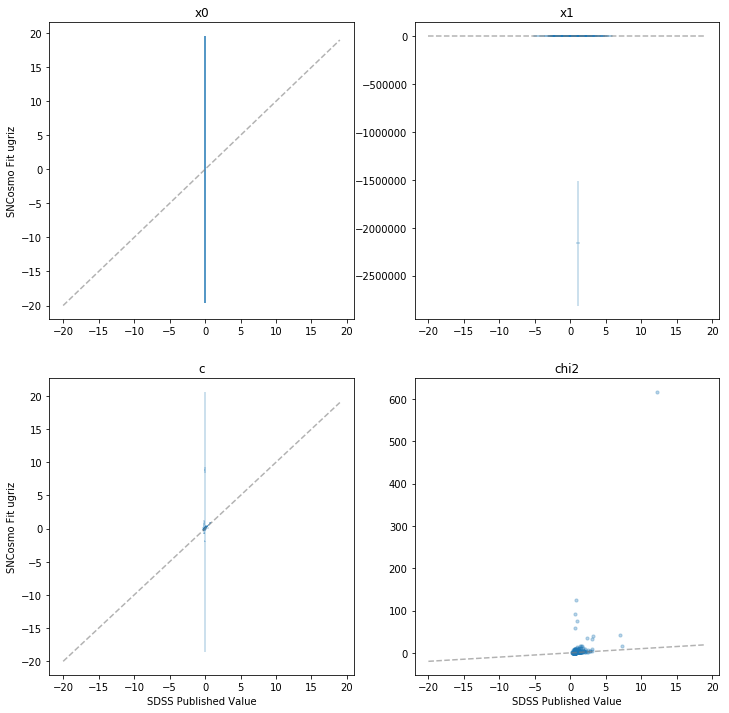

In [35]:
plot_axes = create_sdss_fit_param_figure()

plt.show()

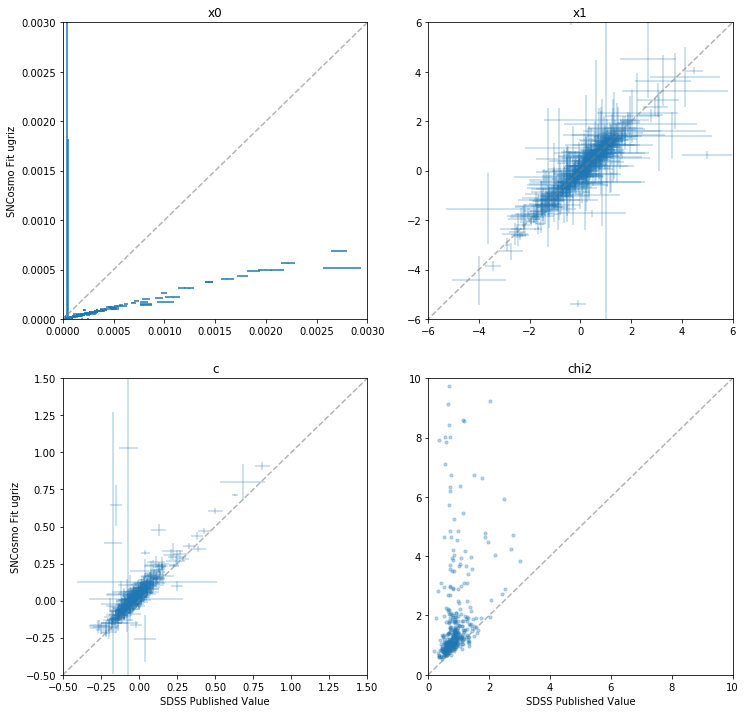

In [38]:
plot_axes = create_sdss_fit_param_figure()

plot_axes[0].set_xlim(0, .003)
plot_axes[0].set_ylim(0, .003)
plot_axes[1].set_xlim(-6, 6)
plot_axes[1].set_ylim(-6, 6)
plot_axes[2].set_xlim(-.5, 1.5)
plot_axes[2].set_ylim(-.5, 1.5)
plot_axes[3].set_xlim(0, 10)
plot_axes[3].set_ylim(0, 10)

plt.show()


In [5]:
data_dict = {col.name: np.array(col) for col in fit_data.itercols()}
source = ColumnDataSource(data=data_dict)

hover = HoverTool(tooltips=[
        ("target", "@cid"),
        ("class", "@class"),
        ("z", "@z"),
        ('z_fit', '@fit_z'),
        ('chi2', '@chi'),
        ('dof', '@dof'),
    ])


In [6]:
figures = []
for value in ('x0', 'x1', 'c', 'chi'):
    fig = figure(tools=_basic_tools + [hover, 'box_select', 'lasso_select'], title=value)
    fig.circle(value + '_sdss', value + '_ugriz', source=source, size=4, alpha=.5)
    fig.xaxis.axis_label = 'SDSS Published Value'
    fig.yaxis.axis_label = 'SNCosmo Fit ugriz'
    figures.append(fig)

grid = gridplot(figures, ncols=2, plot_width=350, plot_height=350)
show(grid)


In [7]:
figures = []
for value in ('x0', 'x1', 'c', 'chi'):
    fig = figure(tools=_basic_tools + [hover, 'box_select', 'lasso_select'], title=value)
    fig.circle('cid', 'delta_' + value, source=source, size=4, alpha=.5)
    fig.xaxis.axis_label = 'CID'
    fig.yaxis.axis_label = 'Percent Residual'
    figures.append(fig)

grid = gridplot(figures, ncols=2, plot_width=350, plot_height=350)
show(grid)
